## BMI for the bionic arm

As a proof of concept we want to show that our bionic arm can replicate the actions performed by the monkey during a trial.

### Import

In [1]:
import numpy as np
from time import sleep, time
import _thread
from statistics import mode

from IPython.display import display, Markdown, clear_output
# widget packages
import ipywidgets as widgets
from sklearn.metrics import accuracy_score

#Import graphics
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation, writers

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
import pickle as pkl

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils.functions import *

In [2]:
# Plotting function
def display_testing_phase_results(conf_matrix, my_labels, errors_distribution, y_test, network_name='network', separators=False, annotate_matrix=True, save=True):
    n_outputs = len(my_labels)
    fig = plt.figure(figsize=(14, 9))
    fig.suptitle(f'Performances of {network_name} testing', fontsize=16)
    gs = gridspec.GridSpec(nrows=3, ncols=3)

    ax1 = fig.add_subplot(gs[:, :-1])
    ax1.set_title('Confusion matrix', fontsize=14)
    conf_matrix_norm = normalize(conf_matrix, axis=1, norm='l1')
    im = ax1.imshow(conf_matrix_norm, cmap=sns.cubehelix_palette(as_cmap=True, light=.98, gamma=0.75), vmin=0, vmax=1)

    ax1.vlines([i + 0.5 for i in range(n_outputs)], -0.5, n_outputs - 0.5, linewidth=2, colors='White')
    ax1.hlines([i + 0.5 for i in range(n_outputs)], -0.5, n_outputs - 0.5, linewidth=2, colors='White')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    if annotate_matrix:
        rows, columns = conf_matrix.shape
        for i in range(rows):
            for j in range(columns):
                c = int(conf_matrix[i][j]) if conf_matrix[i][j].is_integer() else conf_matrix[i][j]
                if c > 0:
                    color = 'White' if conf_matrix_norm[i][j]>=.65 else 'Black'
                    ax1.text(j, i, str(round(c,0)), va='center', ha='center', c=color, fontsize=12)
    ax1.set_xticks(list(range(n_outputs)))
    ax1.set_yticks(list(range(n_outputs)))
    ax1.set_xticklabels(my_labels)
    ax1.set_yticklabels(my_labels)
    ax1.set_ylabel('true value', fontsize=12)
    ax1.set_xlabel('prediction', fontsize=12)
    if separators:
        seps = []
        past_label = my_labels[0]
        for i, l in enumerate(my_labels):
            l = str(l)
            if len(l) == 1 or l[0] != past_label:
                seps.append(i - 0.5)
            past_label = l[0]
        ax1.vlines(seps, -0.5, n_outputs - 0.5, linewidth=1, color='k')
        ax1.hlines(seps, -0.5, n_outputs - 0.5, linewidth=1, color='k')

    ax2 = fig.add_subplot(gs[0, -1])
    ax2.set_title('Distance from the diagonal', fontsize=14)
    x = list(errors_distribution.keys())
    x.sort()
    y = [errors_distribution[distance] for distance in x]
    ax2.step(x, y, where='mid', c='midnightblue')
    ax2.axvspan(-1.5, 1.5, alpha=0.4, color='palevioletred')
    x_max = min(max(list(errors_distribution.keys())), 10)
    lim = x_max if x_max%2 == 0 else x_max-1
    lim = min(lim, 10)
    ax2.set_xticks(list(range(-lim, lim+2, 2)))
    ax2.set_xlim(-x_max, x_max)
    ax2.set_yscale('log')
    ax2.set_ylabel('n errors', fontsize=12)
    ax2.set_xlabel('distance', fontsize=12, y=-10)
    
    e0 = errors_distribution[0]
    e1 = errors_distribution[1]+errors_distribution[-1]
    
    ax3 = fig.add_subplot(gs[1, -1])
    ax3.axis('off')
    ax3.text(0,0.9,f'Distance 0: {round(e0, 3)} [{round(e0/len(y_test)*100, 1)}%]', fontsize=11.5)
    ax3.text(0,0.8,f'Distance ±1: {round(e0+e1, 3)} [{round((e0+e1)/len(y_test)*100, 1)}%]', fontsize=11.5)


    plt.tight_layout(rect=[0, 0, 1, 0.96], pad=3.0)
    if save:
        fig.savefig(f'{PLOTS_FOLDER}/{network_name.replace(" ", "_")}_testing_results.png')
    plt.show()


In [3]:
# USER'S INPUT
WINDOW = 10
PATIENCE = 1

In [4]:
# LOAD MODELS, TRIALS KEPT FOR SIMULATION, AND DATA PRE-PROCESSERS (LABEL ENCODER AND FEATURE SCALER)
state_model = load_model(f'../results/online/state_decoder_{WINDOW}.h5')
shape_model = load_model(f'../results/online/shape_decoder_{WINDOW}.h5')
size_model = load_model(f'../results/online/size_decoder_{WINDOW}.h5')

test_trials = pkl.load(open(f'../data/online/test_dict.pkl', 'rb'))

state_encoder = pkl.load(open(f'../results/online/state_encoder.pkl', 'rb'))
shape_encoder = pkl.load(open(f'../results/online/shape_encoder.pkl', 'rb'))
size_encoder = pkl.load(open(f'../results/online/size_encoder.pkl', 'rb'))

state_scaler = pkl.load(open(f'../results/online/state_scaler.pkl', 'rb'))
shape_scaler = pkl.load(open(f'../results/online/shape_scaler.pkl', 'rb'))
size_scaler = pkl.load(open(f'../results/online/size_scaler.pkl', 'rb'))

In [5]:
from digi.xbee.devices import XBeeDevice

XBEE_PORT = 'COM5'
xbee = XBeeDevice(XBEE_PORT, 115200)
# xbee.open()
print("Node ID: %s \t MAC: %s" % (xbee.get_node_id(), xbee.get_64bit_addr()) )

kinematics_dict = {
    'ring': bytearray(np.random.randint(0, 256, 6).tolist()),
    'cube': bytearray(np.random.randint(0, 256, 6).tolist()),
    'ball': bytearray(np.random.randint(0, 256, 6).tolist()),
    'hcylinder': bytearray(np.random.randint(0, 256, 6).tolist()),
    'box': bytearray(np.random.randint(0, 256, 6).tolist()),
    'vcylinder': bytearray(np.random.randint(0, 256, 6).tolist()),
    'open_hand': bytearray([0]*6),
    'extend': bytearray([0, 255]),
    'lift': bytearray([255, 255]),
    'rest': bytearray([0, 0]),
}

Node ID: None 	 MAC: None


# SIMULATION

In [6]:
# In these arrays I will store the asynchronous prediction
figures = []
pred_states = []
pred_shapes = []
pred_sizes = []

In [7]:
# Functions for the multi threading
def predict_state(window):
    global state_scaler, state_model, pred_states
    window = state_scaler.transform(window.reshape(-1, window.shape[-1])).reshape(window.shape)
    pred = state_model.predict(window)
    pred_states.append(pred.argmax())
    
def predict_shape(window):
    global shape_scaler, shape_model, pred_shapes
    window = shape_scaler.transform(window.reshape(-1, window.shape[-1])).reshape(window.shape)
    pred = shape_model.predict(window)
    pred_shapes.append(pred.argmax())
    
def predict_size(window):
    global size_scaler, size_model, pred_sizes
    window = size_scaler.transform(window.reshape(-1, window.shape[-1])).reshape(window.shape)
    pred = size_model.predict(window)
    pred_sizes.append(pred.argmax())
    
def draw_figure(index, avg_activations, boundaries):
    global figures
    width = WINDOW-1 if index >= WINDOW else index
    nbins = len(avg_activations)
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(20,5))

    # Display the image    
    pre_line = avg_activations[:index-width]
    if not pre_line:
        pre_line = [avg_activations[0]]
    if index >= WINDOW:
        pre_line.append(pre_line[-1])
        pre_line_x = list(range(nbins))[:index-width]
        pre_line_x.append(pre_line_x[-1]+.5)
        ax.step(pre_line_x, pre_line, where='post', color='#1f77b4', alpha=0.5) # before filter


    red_line = avg_activations[index-width:index+1]
    red_line_x = list(range(nbins))[index-width:index+1]
    if index >= WINDOW:
        red_line.insert(0, pre_line[-1])
        red_line_x.insert(0, red_line_x[0]-.5)

    red_line.append(red_line[-1])      
    red_line_x.append(red_line_x[-1]+.5)
    ax.step(red_line_x, red_line, where='post', color='r', alpha=0.9) # under filter

    if index != nbins-1:
        post_line = avg_activations[index+1:]
        post_line_x = list(range(nbins))[index+1:]
        post_line.insert(0, red_line[-1])
        post_line_x.insert(0, post_line_x[0]-.5)
        ax.step(post_line_x, post_line, where='post', color='#1f77b4') # after filter

    # Create a Rectangle patch
    rect_border = patches.Rectangle((index-width-.5, 0), width+1, boundaries[1]*1.15, linewidth=1, edgecolor='r', facecolor='none')
    rect = patches.Rectangle((index-width-.5, 0), width+1, boundaries[1]*1.15, linewidth=1, edgecolor='none', facecolor='y', alpha=0.1)
    
    # Add the patch to the Axes
    ax.add_patch(rect)
    ax.add_patch(rect_border)

    plt.xlim(-2, len(avg_activations)+2)
    figures.append(fig)
    
def generate_payload(current_state):
    global arm_position 
    
    # The bytearray structure is ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky', 'Wrist', 'Elbow', 'Shoulder']
    # Ther last two are not implemented yet in the prototype, therefore they are just simulated here
    
    if current_state == 'Movement' and arm_position == 'Resting':  # The first movement detected will cause the arm to approach the object
        payload = kinematics_dict['open_hand'] + kinematics_dict['extend']
        arm_position = 'Open_Extended'
    
    if current_state == 'Hold':  # if it is the first hold just close the hand, otherwise also lift the object
        if arm_position == 'Open_Extended':
            payload = kinematics_dict[obj_shape.lower()] + kinematics_dict['extend']
            arm_position = 'Closed_Extended'
            
        if arm_position == 'Closed_Extended':
            payload = kinematics_dict[obj_shape.lower()] + kinematics_dict['lift']
            arm_position = 'Lifted'
    
    if current_state == 'End':  # if it is the first end just lay the object, otherwise also retreat the hand
        if arm_position == 'Lifted':
            payload = kinematics_dict[obj_shape.lower()] + kinematics_dict['extend']
            arm_position = 'Closed_Extended'
            
        if arm_position == 'Closed_Extended':
            payload = kinematics_dict['open_hand'] + kinematics_dict['extend']
            arm_position = 'Open_Extended'
            
        if arm_position == 'Open_Extended':
            payload = kinematics_dict['open_hand'] + kinematics_dict['rest']
            arm_position = 'Resting'
            
    return payload


def display_results(results):
    # State Metrics
    pred = results[:, 0]
    conf_matrix, my_labels = my_confusion_matrix(pred, trial_state_grouped[1:results.shape[0]+1], labels=list(macro_classes.keys()), return_labels=True)
    errors_distribution = distance_from_diagonal(conf_matrix)
    display_testing_phase_results(conf_matrix, my_labels, errors_distribution, trial_state, f'states decoder', save=False)

    # Shape Metrics
    pred = results[:, 1]
    good = np.where(pred != '-')
    pred = pred[good]
    conf_matrix, my_labels = my_confusion_matrix(pred, [obj_shape]*len(pred), labels=shape_encoder.classes_, return_labels=True)
    errors_distribution = distance_from_diagonal(conf_matrix)
    display_testing_phase_results(conf_matrix, my_labels, errors_distribution, trial_state, f'shape decoder', save=False)

    # Size Metrics
    pred = results[:, 2]
    good = np.where(pred != '-')
    pred = pred[good]
    conf_matrix, my_labels = my_confusion_matrix(pred, [obj_size]*len(pred), labels=size_encoder.classes_, return_labels=True)
    errors_distribution = distance_from_diagonal(conf_matrix)
    display_testing_phase_results(conf_matrix, my_labels, errors_distribution, trial_state, f'size decoder', save=False)

In [9]:
# Set simulation parameters
OBJ_SHAPE = 3  # shapes: (1)-ring, (2)-cube, (3)-ball, (4)-hCylinder, (5)-box, (6)-vCylinder
OBJ_SIZE = 4  # sizes: 1 to 6

# Simulation preparation
simulation_id = np.int32(str(OBJ_SHAPE+2) + str(OBJ_SIZE))

trial = test_trials[simulation_id]['trial']
obj_shape = test_trials[simulation_id]['shape']
obj_size = test_trials[simulation_id]['size']
trial_state = test_trials[simulation_id]['states'].tolist()
trial_state.append('End') # one last element for the prediction of the last time bin

# apply the macro classes grouping for states
trial_state_grouped = np.array(trial_state, dtype = 'object')
macro_classes = {
    'Waiting': ['Start', 'Rest', 'Motor', 'FixLOn', 'Fix'],
    'Cue': ['Cue'],
    'Planning': ['Mem'],
    'Movement': ['React', 'Go'],
    'Hold': ['Hold', 'Rew'],
    'End': ['Intert', 'End']
}

for mc in macro_classes.keys():
    subclasses = macro_classes[mc]
    indices = np.where(np.isin(trial_state, subclasses))[0] # return an array with all the indices where trial_state belong to subclasses
    trial_state_grouped[indices] = [mc]*len(indices)
            
(channels, nbins) = trial.shape

for i in range(nbins):
    print(i, trial_state_grouped[i])

0 Waiting
1 Waiting
2 Waiting
3 Waiting
4 Waiting
5 Waiting
6 Waiting
7 Waiting
8 Waiting
9 Waiting
10 Waiting
11 Waiting
12 Waiting
13 Waiting
14 Waiting
15 Waiting
16 Waiting
17 Waiting
18 Waiting
19 Waiting
20 Waiting
21 Waiting
22 Waiting
23 Waiting
24 Waiting
25 Waiting
26 Waiting
27 Waiting
28 Waiting
29 Waiting
30 Waiting
31 Waiting
32 Waiting
33 Waiting
34 Waiting
35 Waiting
36 Waiting
37 Waiting
38 Waiting
39 Waiting
40 Waiting
41 Waiting
42 Cue
43 Cue
44 Cue
45 Cue
46 Cue
47 Cue
48 Cue
49 Cue
50 Cue
51 Cue
52 Cue
53 Cue
54 Cue
55 Cue
56 Cue
57 Cue
58 Cue
59 Cue
60 Cue
61 Cue
62 Planning
63 Planning
64 Planning
65 Planning
66 Planning
67 Planning
68 Planning
69 Planning
70 Planning
71 Planning
72 Planning
73 Planning
74 Planning
75 Planning
76 Planning
77 Planning
78 Planning
79 Planning
80 Planning
81 Planning
82 Planning
83 Planning
84 Planning
85 Planning
86 Planning
87 Planning
88 Planning
89 Movement
90 Movement
91 Movement
92 Movement
93 Movement
94 Movement
95 Movement


Simulating cubes 1..
[0] - Next state: Waiting; Shape: -; Size: - -- 0.054s
[1] - Next state: Waiting; Shape: -; Size: - -- 0.032s
[2] - Next state: Waiting; Shape: -; Size: - -- 0.035s
[3] - Next state: Waiting; Shape: -; Size: - -- 0.031s
[4] - Next state: Waiting; Shape: -; Size: - -- 0.032s
[5] - Next state: Waiting; Shape: -; Size: - -- 0.038s
[6] - Next state: Waiting; Shape: -; Size: - -- 0.033s
[7] - Next state: Waiting; Shape: -; Size: - -- 0.033s
[8] - Next state: Waiting; Shape: -; Size: - -- 0.031s
[9] - Next state: Waiting; Shape: -; Size: - -- 0.034s
[10] - Next state: Waiting; Shape: -; Size: - -- 0.034s
[11] - Next state: Waiting; Shape: -; Size: - -- 0.032s
[12] - Next state: Waiting; Shape: -; Size: - -- 0.037s
[13] - Next state: Waiting; Shape: -; Size: - -- 0.031s
[14] - Next state: Waiting; Shape: -; Size: - -- 0.031s
[15] - Next state: Waiting; Shape: -; Size: - -- 0.033s
[16] - Next state: Waiting; Shape: -; Size: - -- 0.032s
[17] - Next state: Waiting; Shape: -;

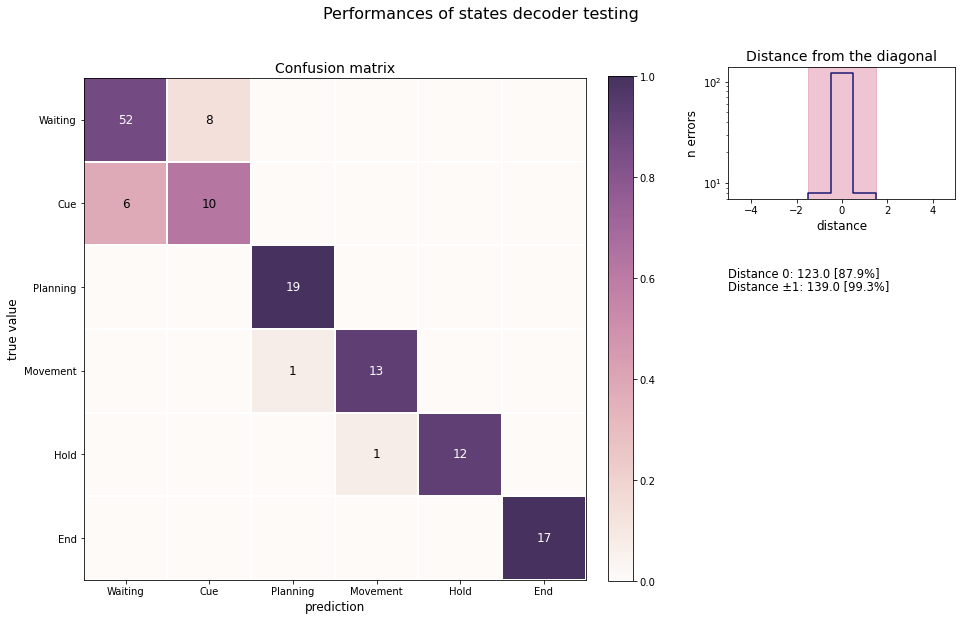

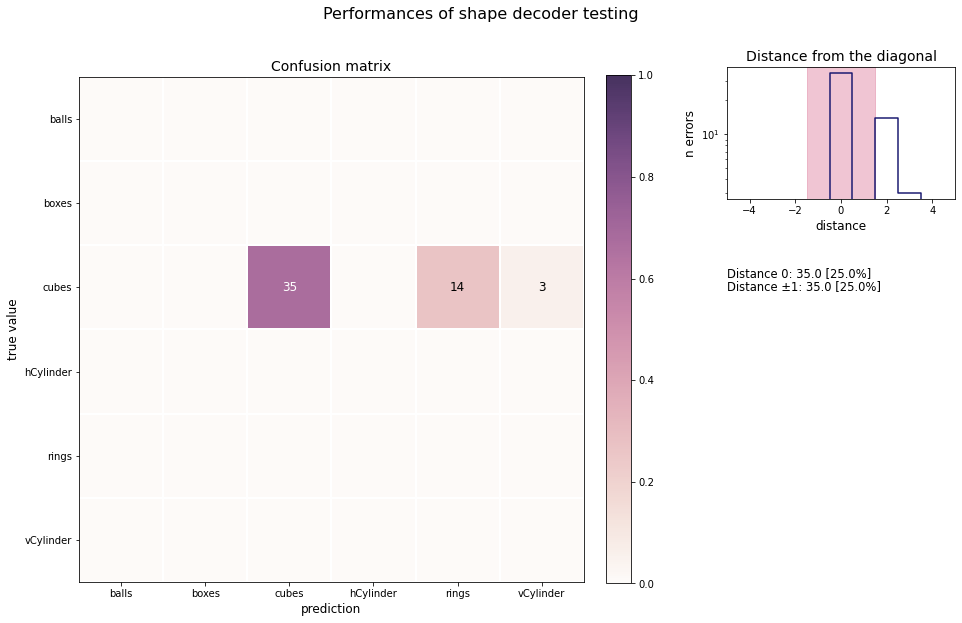

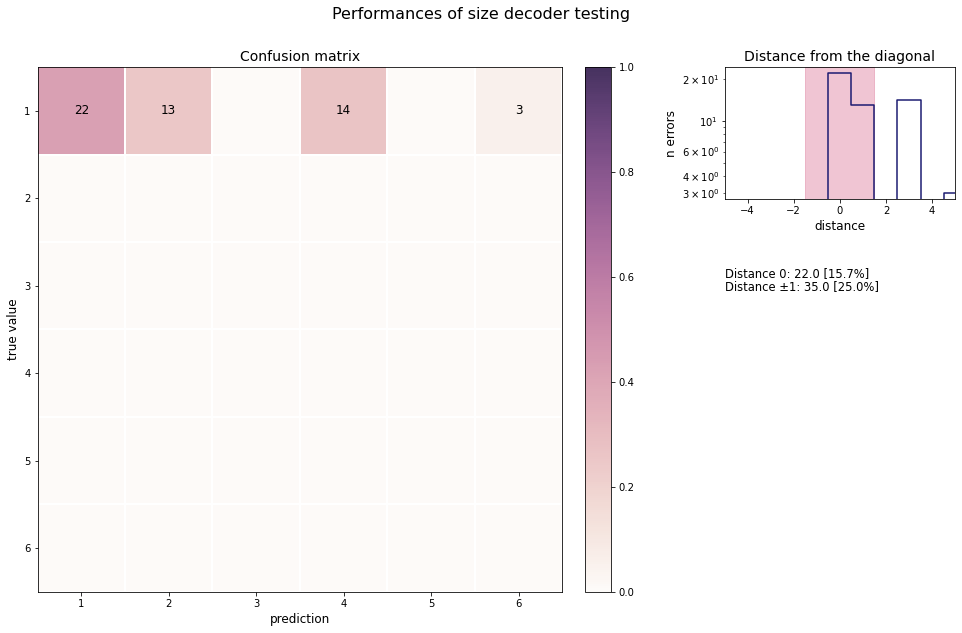

In [17]:
# Set simulation parameters
OBJ_SHAPE = 3  # shapes: (1)-ring, (2)-cube, (3)-ball, (4)-hCylinder, (5)-box, (6)-vCylinder
OBJ_SIZE = 4  # sizes: 1 to 6

# Simulation preparation
simulation_id = np.int32(str(OBJ_SHAPE+2) + str(OBJ_SIZE))

trial = test_trials[simulation_id]['trial']
obj_shape = test_trials[simulation_id]['shape']
obj_size = test_trials[simulation_id]['size']
trial_state = test_trials[simulation_id]['states'].tolist()
trial_state.append('End') # one last element for the prediction of the last time bin

# apply the macro classes grouping for states
trial_state_grouped = np.array(trial_state, dtype = 'object')
macro_classes = {
    'Waiting': ['Start', 'Rest', 'Motor', 'FixLOn', 'Fix'],
    'Cue': ['Cue'],
    'Planning': ['Mem'],
    'Movement': ['React', 'Go'],
    'Hold': ['Hold', 'Rew'],
    'End': ['Intert', 'End']
}

for mc in macro_classes.keys():
    subclasses = macro_classes[mc]
    indices = np.where(np.isin(trial_state, subclasses))[0] # return an array with all the indices where trial_state belong to subclasses
    trial_state_grouped[indices] = [mc]*len(indices)
            
(channels, nbins) = trial.shape

# Start simulation
results = []
print(f'Simulating {obj_shape} {obj_size}..')

arm_position = 'Resting'

for index in range(nbins):
    start_t = time()
    # Get new window
    window = trial[np.newaxis, :, max(0, index-WINDOW+1):index+1]
    if index < 9:
        pad = np.zeros((1, window.shape[1], WINDOW-index-1))
        window = np.concatenate((pad, window), axis=2)
    
    # Predict state
    predict_state(window)
    r1 = state_encoder.classes_[mode(pred_states[max(-PATIENCE, -len(pred_states)):])]
    
    # If suitable, predict also object shape and size
    if r1 in ['Cue', 'Planning', 'Movement']:
        predict_shape(window)
        predict_size(window)
        r2 = shape_encoder.classes_[mode(pred_shapes[max(-PATIENCE, -len(pred_states)):])]
        r3 = size_encoder.classes_[mode(pred_sizes[max(-PATIENCE, -len(pred_states)):])]
    else:
        r2 = '-'
        r3 = '-'
    
#     xbee.send_data(aggregator_xbee, generate_payload(r1))
    
    exe_time = round(time()-start_t, 3)
    results.append((r1, r2, r3, exe_time))

    print(f'[{index}] - '
          f'Next state: {r1}; '
          f'Shape: {r2}; '
          f'Size: {r3} -- {exe_time}s')
    
# If desired, you can print the metrics at the end of the simulation
display_results(np.array(results))